In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import scanpy as sc
from pyplier import PLIER, PLIERResults
from pyplier.plotting import plotMat, plotTopZ, plotTopZallPath
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

/home/milo/.cache/pypoetry/virtualenvs/pyplier-Idb-akax-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plierRes = PLIERResults.from_disk("pbmc3k_plier_res.json.gz")

In [3]:
plierRes.B.to_csv("pbmc3k_B.csv.gz")

In [4]:
pbmc3k = sc.datasets.pbmc3k_processed()

In [5]:
priorMat = pd.read_csv("reactome.csv.gz", index_col="genes")

In [6]:
data = pd.DataFrame(pbmc3k.X, index=pbmc3k.obs_names, columns=pbmc3k.var_names).T

In [7]:
top = 10
index = None
regress = False
allLVs = False

In [20]:
data = data.loc[plierRes.Z.index, :]
priorMat = priorMat.loc[plierRes.Z.index.intersection(priorMat.index), :]
plierRes.U.columns[np.where(plierRes.U.sum(axis=0) > 0)]

if allLVs:
    if index is not None:
        ii = plierRes.U.columns.intersection(index) # use `intersection` so we don't have an issue with trying to plot non-existent LVs
    else:
        ii = plierRes.U.columns
elif index is not None:
    ii = plierRes.U.columns[plierRes.U.sum() > 0].intersection(index)
else:
    ii = plierRes.U.columns[plierRes.U.sum() > 0]

In [21]:
z_ranks = plierRes.Z.loc[:, ii].rank(ascending=False)
nnz_ranks = [z_ranks[i].index[[z_ranks[i] <= top]].values for i in ii]

nn = np.concatenate(nnz_ranks)

/home/milo/.cache/pypoetry/virtualenvs/pyplier-Idb-akax-py3.9/lib/python3.9/site-packages/pandas/core/indexes/base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [22]:
nncol = (
    plierRes.B.index[plierRes.Z.columns.isin(ii)]
    .repeat([len(_) for _ in nnz_ranks])
).to_series()

In [23]:
nnpath = pd.concat(
        [
            priorMat.loc[x, plierRes.U.loc[plierRes.U.loc[:, y] > 0, y].index].sum(
                axis=1
            )
            > 0
            for x, y in zip(nnz_ranks, ii)
        ],
        axis=0,
    )

In [24]:
nnindex = ii.repeat([len(_) for _ in nnz_ranks])

In [25]:
nnrep = np.unique(nn)[np.unique(nn, return_counts=True)[1] > 1]

In [26]:
if len(nnrep) > 0:
    nnrep_im = np.intersect1d(nn, nnrep, return_indices=True)[1]
    nn = np.delete(nn, nnrep_im)
    nncol = nncol.iloc[[_ for _ in range(len(nncol)) if _ not in nnrep_im]]
    nnpath = nnpath.iloc[[_ for _ in range(len(nnpath)) if _ not in nnrep_im]]
    nnindex = np.delete(nnindex, nnrep_im)
    nnpath.replace({True: "inPathway", False: "notInPathway"}, inplace=True)

In [27]:
nnpath.replace({True: "inPathway", False: "notInPathway"}, inplace=True)

In [28]:
toplot = data.loc[nn,:]

In [29]:
present_lut = {
        "inPathway": mcolors.to_rgb(mcolors.CSS4_COLORS["black"]),
        "notInPathway": mcolors.to_rgb(mcolors.CSS4_COLORS["beige"]),
    }

In [30]:
pathway_pal = sns.color_palette(
    "hsv", n_colors=nncol.unique().size
)
np.random.shuffle(pathway_pal)
pathway_lut = {x: y for x, y in zip(nncol.unique(), pathway_pal)}

In [32]:
nncol.map(pathway_lut)

1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS    (0.12389518271871214, 1.0, 0.0)
1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS    (0.12389518271871214, 1.0, 0.0)
1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS    (0.12389518271871214, 1.0, 0.0)
1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS    (0.12389518271871214, 1.0, 0.0)
1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS    (0.12389518271871214, 1.0, 0.0)
                                                                ...               
124,REACTOME_AMYLOID_FIBER_FORMATION                 (1.0, 0.741177211765447, 0.0)
124,REACTOME_AMYLOID_FIBER_FORMATION                 (1.0, 0.741177211765447, 0.0)
124,REACTOME_AMYLOID_FIBER_FORMATION                 (1.0, 0.741177211765447, 0.0)
124,REACTOME_AMYLOID_FIBER_FORMATION                 (1.0, 0.741177211765447, 0.0)
124,REACTOME_AMYLOID_FIBER_FORMATION                 (1.0, 0.741177211765447, 0.0)
Length: 669, dtype: object

In [33]:
nnpath

S100A12     notInPathway
S100A8         inPathway
GPX1           inPathway
FOLR3       notInPathway
ASGR1       notInPathway
                ...     
CST3           inPathway
TYROBP         inPathway
APOBEC3A    notInPathway
APOBEC3B    notInPathway
TYMP        notInPathway
Length: 669, dtype: object

In [34]:
nnpath.map(present_lut)

S100A12     (0.9607843137254902, 0.9607843137254902, 0.862...
S100A8                                        (0.0, 0.0, 0.0)
GPX1                                          (0.0, 0.0, 0.0)
FOLR3       (0.9607843137254902, 0.9607843137254902, 0.862...
ASGR1       (0.9607843137254902, 0.9607843137254902, 0.862...
                                  ...                        
CST3                                          (0.0, 0.0, 0.0)
TYROBP                                        (0.0, 0.0, 0.0)
APOBEC3A    (0.9607843137254902, 0.9607843137254902, 0.862...
APOBEC3B    (0.9607843137254902, 0.9607843137254902, 0.862...
TYMP        (0.9607843137254902, 0.9607843137254902, 0.862...
Length: 669, dtype: object

In [35]:
row_annotations = pd.DataFrame(
    {
        "pathway": nncol.map(pathway_lut).values,
        "present": nnpath.map(present_lut).values,
    },
    index=nnpath.index
)

In [64]:
pathway_labels

Index(['1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS',
       '1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS',
       '1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS',
       '1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS',
       '1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS',
       '1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS',
       '1,REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS',
       '2,REACTOME_COMPLEMENT_CASCADE', '2,REACTOME_COMPLEMENT_CASCADE',
       '2,REACTOME_COMPLEMENT_CASCADE',
       ...
       '124,REACTOME_AMYLOID_FIBER_FORMATION',
       '124,REACTOME_AMYLOID_FIBER_FORMATION',
       '124,REACTOME_AMYLOID_FIBER_FORMATION',
       '124,REACTOME_AMYLOID_FIBER_FORMATION',
       '124,REACTOME_AMYLOID_FIBER_FORMATION',
       '124,REACTOME_AMYLOID_FIBER_FORMATION',
       '124,REACTOME_AMYLOID_FIBER_FORMATION',
       '124,REACTOME_AMYLOID_FIBER_FORMATION',
       '124,REACTOME_AMYLOID_FIBER_FORMATION',
       '124,REACTOME_AMYLOID_FIBER_FORMATION'],

In [ ]:
pathway_pal = sns.color_palette("hls", n_colors=pathway_labels.unique().size)
#np.random.shuffle(pathway_pal)
pathway_lut = {x: y for x, y in zip(nncol["pathway"].unique(), pathway_pal)}

nncol = nncol.replace({True: "inPathway", False: "notinPathway"})
row_annotations = pd.DataFrame(
    {
        "pathway": nncol["pathway"].map(pathway_lut),
        "present": nncol["present"].map(present_lut),
    }
).set_index(pathway_gene_index)

In [ ]:
pathway_labels = row_annotations.index.get_level_values("pathway")
pathway_colors = pd.Series(pathway_labels, index=row_annotations.index).map(pathway_lut)

In [50]:
import statsmodels.api as sm

In [51]:
if regress:
    for i in tqdm(ii):
        gi = np.where(nnindex == i)[0]
        toplot.iloc[gi, :] = (
            sm.GLS(
                toplot.iloc[gi, :].T,
                plierRes.B.drop(index=plierRes.B.index[0]).loc[:, toplot.columns].T,
            )
            .fit()
            .resid.T
        )

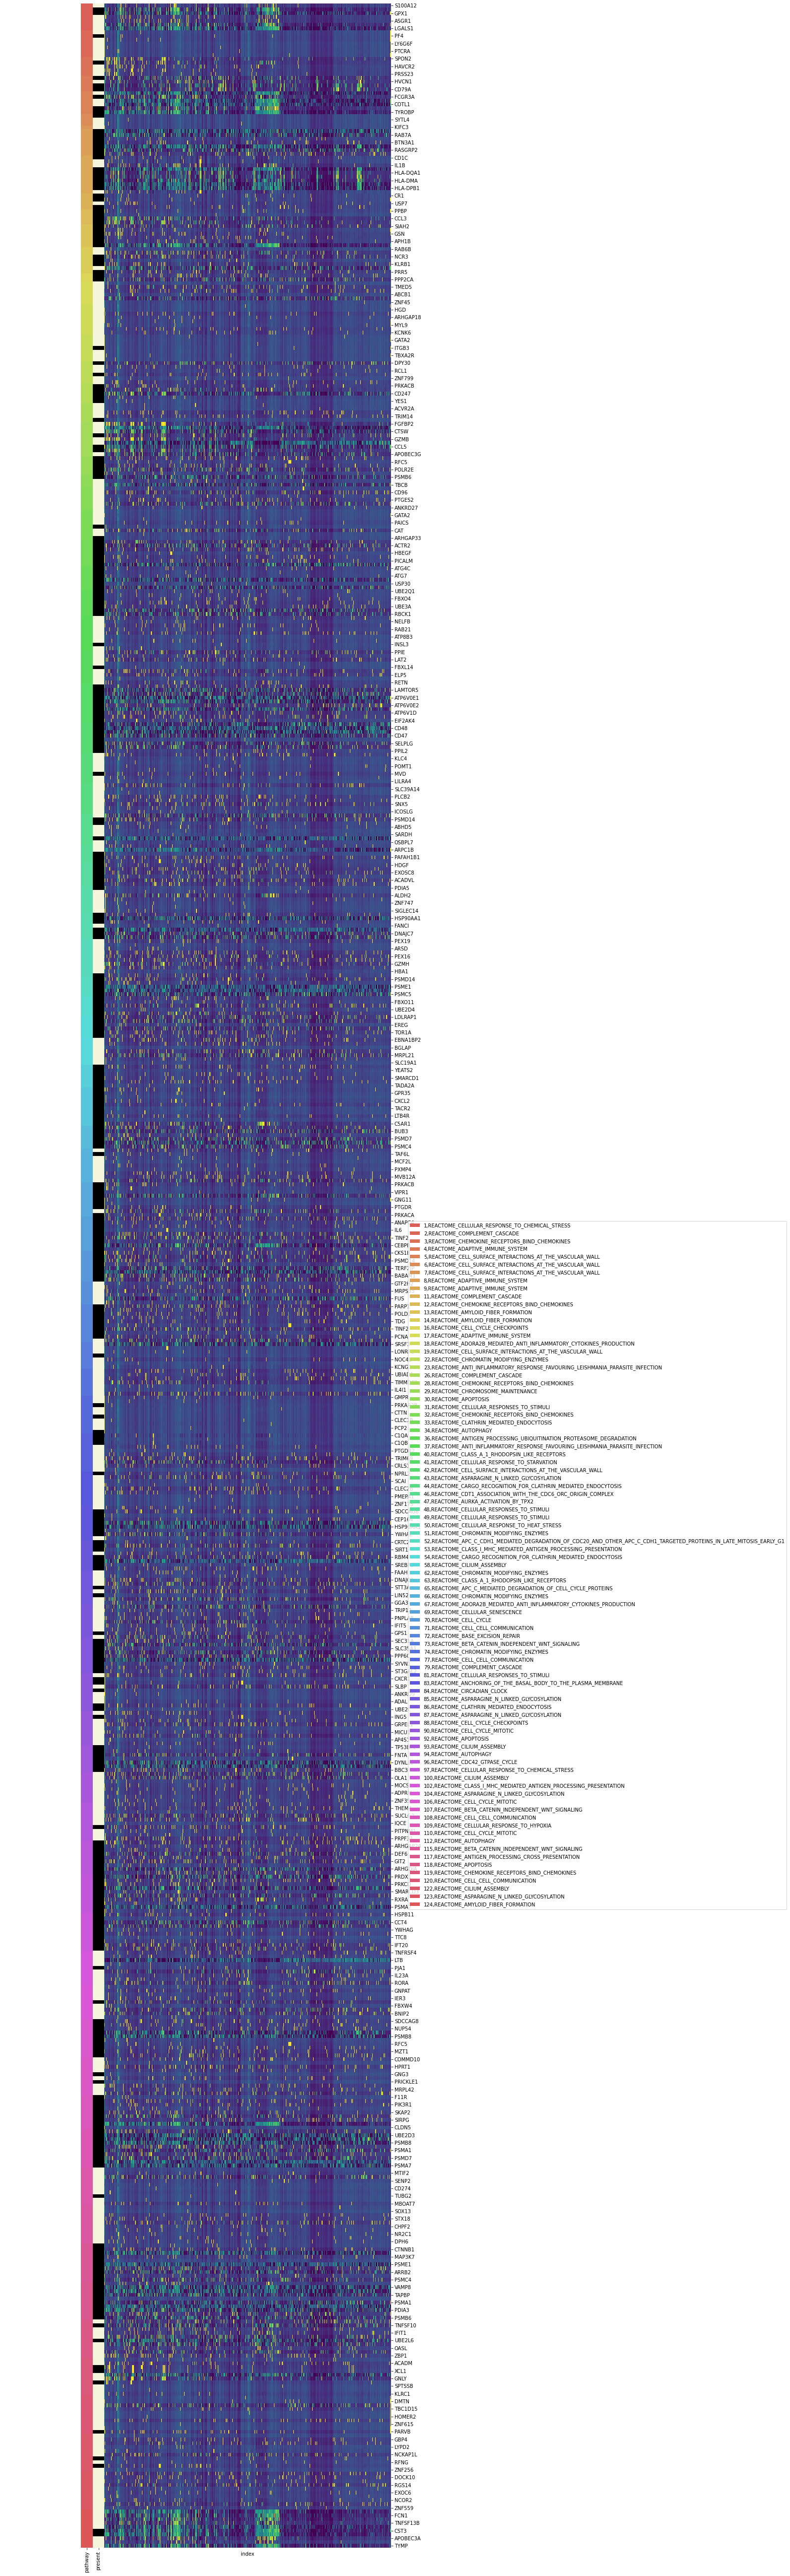

In [ ]:
g = sns.clustermap(
    data=np.add(toplot, abs(toplot.min(axis=0))),
    row_cluster=False,
    cmap="viridis",
    # cmap=sns.cubehelix_palette(hue=2),
    robust=True,
    linecolor="black",
    row_colors=row_annotations.droplevel("pathway"),
    figsize=(12,90),
    # z_score=1,
    xticklabels=False,
)
g.ax_col_dendrogram.set_visible(False)
g.ax_cbar.set_visible(False)
l1 = g.ax_heatmap.legend(
    handles=[Patch(facecolor=pathway_lut[name]) for name in pathway_lut],
    labels=pathway_lut.keys(),
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1.05,0.25),
)

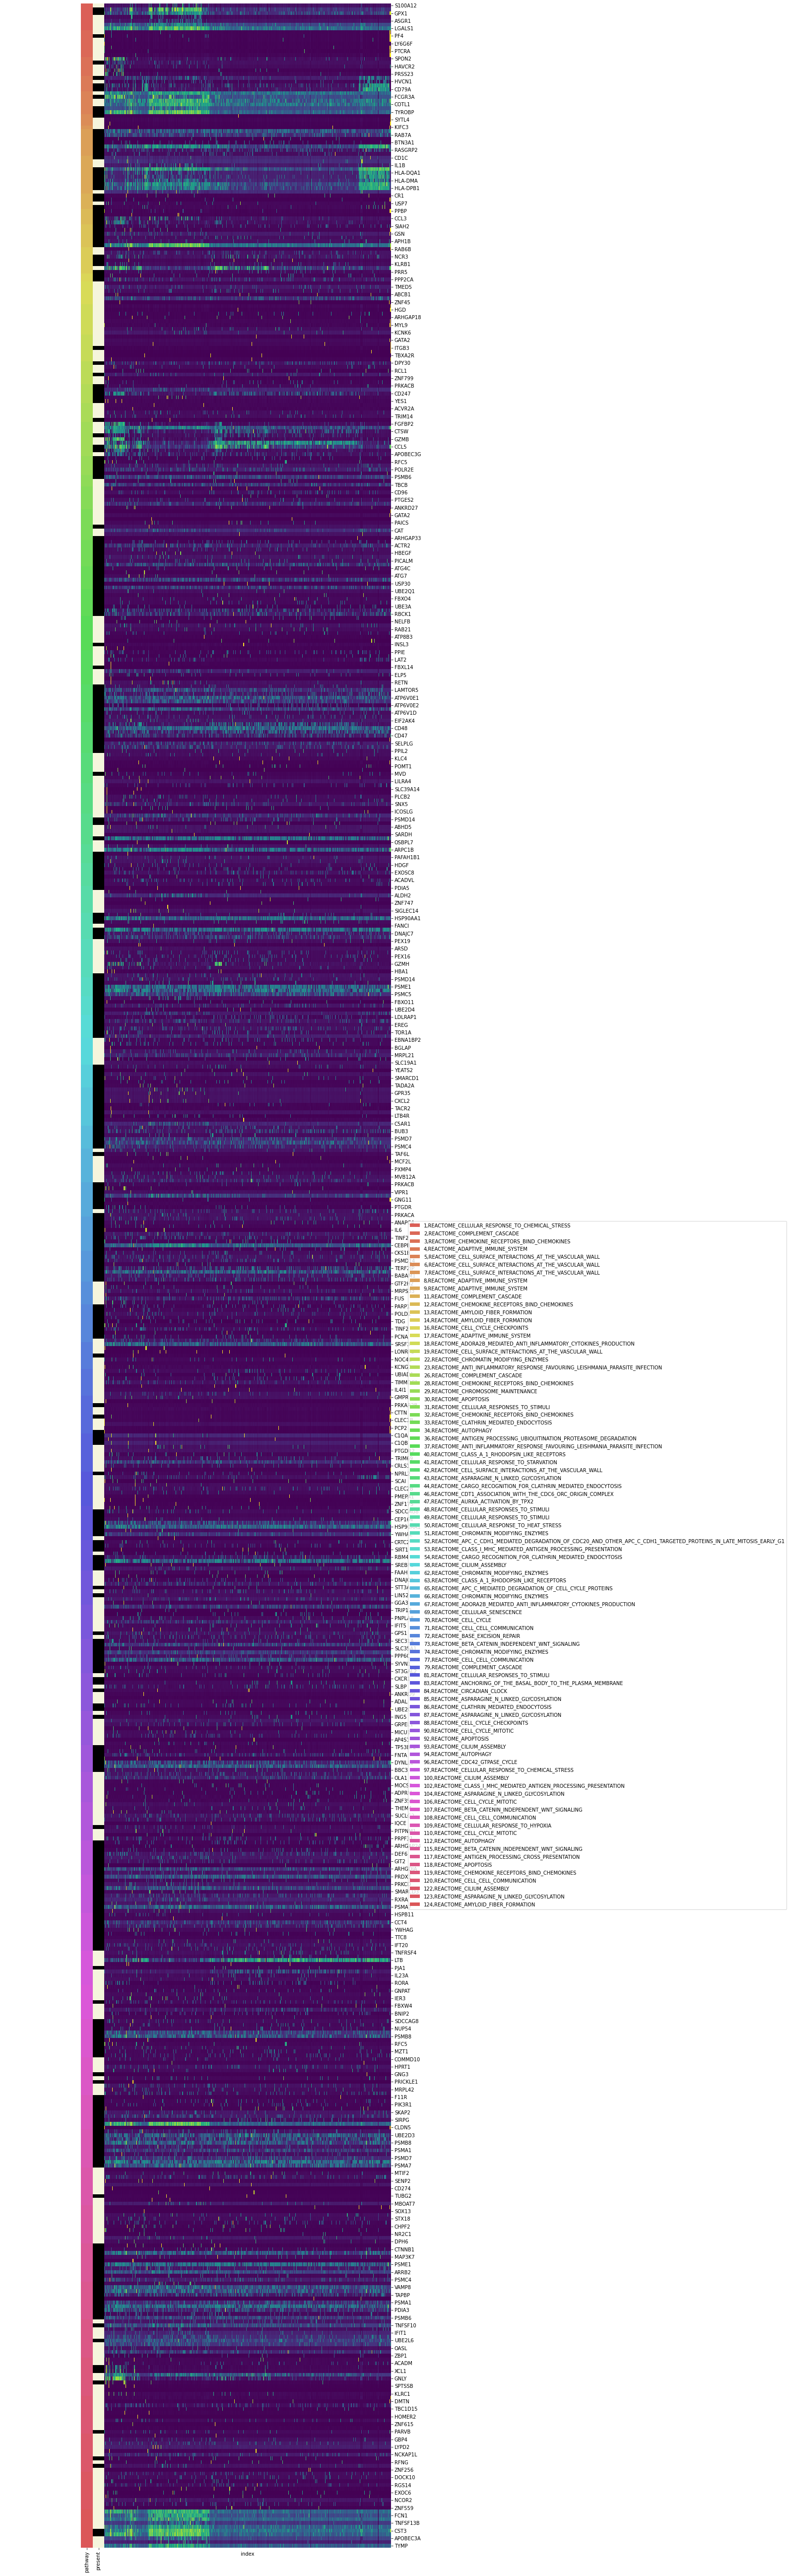

In [62]:
g = sns.clustermap(
    data=toplot,
    row_cluster=False,
    cmap="viridis",
    # cmap=sns.cubehelix_palette(hue=2),
    robust=False,
    linecolor="black",
    row_colors=row_annotations.droplevel("pathway"),
    figsize=(12,90),
    # z_score=0,
    standard_scale=0,
    xticklabels=False,
)
g.ax_col_dendrogram.set_visible(False)
g.ax_cbar.set_visible(False)
l1 = g.ax_heatmap.legend(
    handles=[Patch(facecolor=pathway_lut[name]) for name in pathway_lut],
    labels=pathway_lut.keys(),
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1.05,0.25),
)

In [63]:
type(g)

seaborn.matrix.ClusterGrid